In [1]:
import os
import glob
import pickle
import ast
import json
import numpy as np
import seaborn as sns
import pandas as pd
from dance_evaluation import *
import matplotlib.pyplot as plt
# import analyze_hits_pos as anlyz



### Analyze Hits from multiple sensors

In [2]:
def pairwise_consistency(set_a, set_b):
    intersection_count = len(set_a.intersection(set_b))
    return round((intersection_count / max(len(set_a), len(set_b))) * 100, 2) if max(len(set_a), len(set_b)) > 0 else 0

config1 = {"a": 70, "b": 145, "mode": ["uni", "bi"], "norm_mode": "z-score" }
config2 = {"a": 60, "b": 180, "mode": ["uni", "bi"], "norm_mode": "z-score" }

configs = [config1, config2]

bpm_dict = {
    "bpm_avg_x": 0, "bpm_avg_y": 1, "bpm_avg_xy": 2, "bpm_mode_x": 3,
    "bpm_mode_y": 4, "bpm_mode_xy": 5, "bpm_median_x": 6, "bpm_median_y": 7,
    "bpm_median_xy": 8
}

foot1s_name = "right_ankle"

for cfg in configs:
    a = cfg["a"]
    b = cfg["b"]
    norm_mode = cfg['norm_mode']
    for mode in cfg["mode"]:
        
        foot_1S_df = pd.read_csv(f"./aist_pos1s/{norm_mode}/tempo_{a}_{b}/foot/{foot1s_name}_zero_{mode}_{a}_{b}.csv")
        total = foot_1S_df.shape[0] # total number of 

        json_hits_data = {}
        consistency_data = {}
        for key in bpm_dict.keys():


            left_hand_score = pd.read_csv(f"./aist_pos1s/{norm_mode}/tempo_{a}_{b}/score/hand/left_wrist_{mode}_{a}_{b}_score.csv")
            right_hand_score = pd.read_csv(f"./aist_pos1s/{norm_mode}/tempo_{a}_{b}/score/hand/right_wrist_{mode}_{a}_{b}_score.csv")

            left_ankle_score = pd.read_csv(f"./aist_pos1s/{norm_mode}/tempo_{a}_{b}/score/foot/left_ankle_{mode}_{a}_{b}_score.csv")
            right_ankle_score = pd.read_csv(f"./aist_pos1s/{norm_mode}/tempo_{a}_{b}/score/foot/right_ankle_{mode}_{a}_{b}_score.csv")

            left_hand_score["hits_idx"] = left_hand_score["hits_idx"].apply(ast.literal_eval)   # convert string to list
            right_hand_score["hits_idx"] = right_hand_score["hits_idx"].apply(ast.literal_eval)

            left_ankle_score["hits_idx"] = left_ankle_score["hits_idx"].apply(ast.literal_eval)
            right_ankle_score["hits_idx"] = right_ankle_score["hits_idx"].apply(ast.literal_eval)

            Lh_hits_idx = set(left_hand_score.iloc[bpm_dict[key]]["hits_idx"])
            Rh_hits_idx = set(right_hand_score.iloc[bpm_dict[key]]["hits_idx"])

            Lf_hits_idx = set(left_ankle_score.iloc[bpm_dict[key]]["hits_idx"])
            Rf_hits_idx = set(right_ankle_score.iloc[bpm_dict[key]]["hits_idx"])

            all_hits_idx = set().union(*[Lh_hits_idx, Rh_hits_idx, Lf_hits_idx, Rf_hits_idx])

            # hits statistics
            hits_stats = {"hits_summary": {"segment": ["Left Hand", "Right Hand", "Left Foot", "Right Foot", "Combined"],
                                        "hits_idx": [Lh_hits_idx, Rh_hits_idx, Lf_hits_idx, Rf_hits_idx, all_hits_idx],
                                        "hits_count": [len(Lh_hits_idx), len(Rh_hits_idx), len(Lf_hits_idx), len(Rf_hits_idx), len(all_hits_idx)],
                                        "total": [total, total, total, total, total],
                                        "hits_percentage": [len(Lh_hits_idx) / total * 100, len(Rh_hits_idx) / total * 100,
                                                            len(Lf_hits_idx) / total * 100, len(Rf_hits_idx) / total * 100,
                                                            len(all_hits_idx) / total * 100]},
                        
                        "hit_idx_by_limb": {"Left Hand": Lh_hits_idx, "Right Hand": Rh_hits_idx,
                                            "Left Foot": Lf_hits_idx,"Right Foot": Rf_hits_idx,
                                            "Combined": all_hits_idx},
                        }
            json_hits_data[key] = hits_stats
            
            # Calculate pairwise consistency scores
            consistency_scores = {
                "Lh-Rh (Hands)": pairwise_consistency(Lh_hits_idx, Rh_hits_idx),
                "Lf-Rf (Feet)": pairwise_consistency(Lf_hits_idx, Rf_hits_idx),
                "Lh-Lf (Left Side)": pairwise_consistency(Lh_hits_idx, Lf_hits_idx),
                "Rh-Rf (Right Side)": pairwise_consistency(Rh_hits_idx, Rf_hits_idx),
                "Lh-Rf (Diagonal)": pairwise_consistency(Lh_hits_idx, Rf_hits_idx),
                "Rh-Lf (Diagonal)": pairwise_consistency(Rh_hits_idx, Lf_hits_idx)
            }

            consistency_data[key] = consistency_scores
                
        save_path1 = f"./stats_pos/{norm_mode}/tempo_{a}_{b}/{mode}/hit_stats_{mode}_{a}_{b}.pkl"
        save_path2 = f"./stats_pos/{norm_mode}/tempo_{a}_{b}/{mode}/consistency_stats_{mode}_{a}_{b}.pkl"
        
        with open(save_path1, "wb") as f:
            pickle.dump(json_hits_data, f)
        
        with open(save_path2, "wb") as f:
            pickle.dump(consistency_data, f)    
            
            
    # uncomment to save csv
    # df_data = pd.DataFrame(hits_data)
    # df_data.to_csv(f"./stats_pos/{norm_mode}/tempo_{a}_{b}/{mode}/{metric}/hits_{mode}_{a}_{b}.csv", index=False)
    # print("Saved hits data to csv")

print("total:", total)
print("L hand hits:", len(Lh_hits_idx))
print("R hand hits:", len(Rh_hits_idx))
print("L foot hits:", len(Lf_hits_idx))
print("R foot hits:", len(Rf_hits_idx))
print("All hits:", len(all_hits_idx))

total: 1341
L hand hits: 216
R hand hits: 195
L foot hits: 254
R foot hits: 227
All hits: 552


#### Genre-wise

In [24]:
config1 = {"a": 70, "b": 145, "mode": ["uni", "bi"], "norm_mode": "z-score" }
config2 = {"a": 60, "b": 180, "mode": ["uni", "bi"], "norm_mode": "z-score" }

configs = [config1, config2]

bpm_dict = {
    "bpm_avg_x": 0, "bpm_avg_y": 1, "bpm_avg_xy": 2, "bpm_mode_x": 3,
    "bpm_mode_y": 4, "bpm_mode_xy": 5, "bpm_median_x": 6, "bpm_median_y": 7,
    "bpm_median_xy": 8
}

# Load genre mappings
with open("genreID_count_mapping.json", "r") as file:
    genre_Tcount = json.load(file)

with open("genre_symbols_mapping.json", "r") as file:
    genre_name = json.load(file)

for cfg in configs:
    a = cfg["a"]
    b = cfg["b"]
    norm_mode = cfg['norm_mode']
    for mode in cfg["mode"]:
        
        foot_1S_df = pd.read_csv(f"./aist_pos1s/{norm_mode}/tempo_{a}_{b}/foot/{foot1s_name}_zero_{mode}_{a}_{b}.csv")
        total = foot_1S_df.shape[0] # total number of 

        json_hits_genrewise = {}
        consistency_genrewise = {}
        
        for key in bpm_dict.keys():
            
            hits_list = {
            "left_hand": json_hits_data[key]['hit_idx_by_limb']['Left Hand'],
            "right_hand": json_hits_data[key]['hit_idx_by_limb']['Right Hand'],
            "left_foot": json_hits_data[key]['hit_idx_by_limb']['Left Foot'],
            "right_foot": json_hits_data[key]['hit_idx_by_limb']['Right Foot'],
            "Combined": json_hits_data[key]['hit_idx_by_limb']['Combined'],
            }
            
            # Initialize final dataframe with unique genres
            final_df = pd.DataFrame(list(genre_name.items()), columns=["dance_genre", "genre"])
            final_df["total"] = final_df["dance_genre"].map(genre_Tcount)

            # Dictionary to store genre-wise hit indices per limb
            genre_wise_hits = {limb: {} for limb in hits_list.keys()}

            # For each body segment, find genre-wise hit indices
            for limb, hit_indices in hits_list.items():
                hit_idx_list = list(hit_indices)
                hit_df = foot_1S_df.iloc[hit_idx_list]  # DataFrame for estimated hits of that limb

                # Group by genre and store indices per genre
                for genre_id, group in hit_df.groupby("dance_genre"):
                    genre_wise_hits[limb][genre_id] = set(group.index)  # Store as set for easy intersection

                # Count per genre for the final summary
                grouped = hit_df.groupby(['dance_genre']).size().reset_index(name=f'{limb}_count')
                final_df = final_df.merge(grouped, on='dance_genre', how='left')
                final_df[f'{limb}_count'] = final_df[f'{limb}_count'].fillna(0).astype(int)
                final_df[f'{limb}_percentage'] = round((final_df[f'{limb}_count'] / final_df['total']) * 100, 2)

            # Clean final_df to keep genre and counts
            hits_genrewise_df = final_df[['genre', 'total'] + [f'{limb}_count' for limb in hits_list.keys()] + [f'{limb}_percentage' for limb in hits_list.keys()]]


            # Calculate pairwise consistency per genre
            consistency_results = []
            for genre in final_df["genre"]:
                # Get genre ID from genre_name mapping
                genre_id = [k for k, v in genre_name.items() if v == genre][0]

                # Extract sets per limb for that genre
                lh = genre_wise_hits["left_hand"].get(genre_id, set())
                rh = genre_wise_hits["right_hand"].get(genre_id, set())
                lf = genre_wise_hits["left_foot"].get(genre_id, set())
                rf = genre_wise_hits["right_foot"].get(genre_id, set())

                # Compute pairwise consistency
                consistency_scores = {
                    "genre": genre,
                    "Lhand-Rhand (Hands)": pairwise_consistency(lh, rh),
                    "Lfoot-Rfoot (Feet)": pairwise_consistency(lf, rf),
                    "Lhand-Lfoot (Left Side)": pairwise_consistency(lh, lf),
                    "Rhand-Rfoot (Right Side)": pairwise_consistency(rh, rf),
                    "Lhand-Rfoot (Diagonal)": pairwise_consistency(lh, rf),
                    "Rhand-Lfoot (Diagonal)": pairwise_consistency(rh, lf)
                }
                consistency_results.append(consistency_scores)


            consistency_genrewise_df = pd.DataFrame(consistency_results)       
            
            json_hits_genrewise[key] = hits_genrewise_df
            consistency_genrewise[key] = consistency_genrewise_df    
        
        save_path3 = f"./stats_pos/{norm_mode}/tempo_{a}_{b}/{mode}/hit_stats_genrewise_{mode}_{a}_{b}.pkl"
        save_path4 = f"./stats_pos/{norm_mode}/tempo_{a}_{b}/{mode}/consistency_stats_genrewise_{mode}_{a}_{b}.pkl"
        
        with open(save_path3, "wb") as f:
            pickle.dump(json_hits_genrewise, f)
        
        with open(save_path4, "wb") as f:
            pickle.dump(consistency_genrewise, f)

#### Overall Consistency Score Across Genres

In [ ]:
# function to calculate pairwise consistency
# def pairwise_consistency(set_a, set_b):
#     intersection_count = len(set_a.intersection(set_b))
#     return round((intersection_count / max(len(set_a), len(set_b))) * 100, 2) if max(len(set_a), len(set_b)) > 0 else 0
    
# # Calculate pairwise consistency scores
# consistency_scores = {
#     "Lh-Rh (Hands)": pairwise_consistency(Lh_hits_idx, Rh_hits_idx),
#     "Lf-Rf (Feet)": pairwise_consistency(Lf_hits_idx, Rf_hits_idx),
#     "Lh-Lf (Left Side)": pairwise_consistency(Lh_hits_idx, Lf_hits_idx),
#     "Rh-Rf (Right Side)": pairwise_consistency(Rh_hits_idx, Rf_hits_idx),
#     "Lh-Rf (Diagonal)": pairwise_consistency(Lh_hits_idx, Rf_hits_idx),
#     "Rh-Lf (Diagonal)": pairwise_consistency(Rh_hits_idx, Lf_hits_idx)
# }
   
# consistency_data = pd.DataFrame(list(consistency_scores.items()), columns=["Pair", "Consistency Score"])
# consistency_data.to_csv(f"./stats_pos/{norm_mode}/tempo_{a}_{b}/{mode}/{metric}/consistency_{mode}_{a}_{b}.csv", index=False)
# print("Saved consistency data to csv")

ovral_consistency_df = pd.DataFrame(list(consistency_scores.items()), columns=["Pair", "Consistency Score"])

# Plotting the bar plot
plt.figure(figsize=(4, 2), dpi=150)
sns.barplot(data=ovral_consistency_df, x="Consistency Score", y="Pair", palette="viridis")

# Formatting the plot
plt.title(f"Inter-Limb Tempo Consistency Scores Across All Genres (zero velocity, {mode})")
plt.xlabel("Consistency Score")
plt.ylabel("Pair")
plt.xlim(0, 100)  # Assuming scores are percentages; adjust if needed
plt.grid(axis='x', linestyle="--", alpha=0.7)
plt.show()



#### Genre-Wise Consistency Score Barplot

In [ ]:
foot1s_name = "right_ankle"
foot_1S_df = pd.read_csv(f"./aist_pos1s/{norm_mode}/tempo_{a}_{b}/foot/{foot1s_name}_zero_{mode}_{a}_{b}.csv")

# Load genre mappings
with open("genreID_count_mapping.json", "r") as file:
    genre_Tcount = json.load(file)

with open("genre_symbols_mapping.json", "r") as file:
    genre_name = json.load(file)
    
hits_list = {
    "left_hand": Lh_hits_idx,
    "right_hand": Rh_hits_idx,
    "left_foot": Lf_hits_idx,
    "right_foot": Rf_hits_idx,
    "Combined": all_hits_idx  # Combined Union
}

# Initialize final dataframe with unique genres
final_df = pd.DataFrame(list(genre_name.items()), columns=["dance_genre", "genre"])
final_df["total"] = final_df["dance_genre"].map(genre_Tcount)

# Dictionary to store genre-wise hit indices per limb
genre_wise_hits = {limb: {} for limb in hits_list.keys()}

# For each body segment, find genre-wise hit indices
for limb, hit_indices in hits_list.items():
    hit_idx_list = list(hit_indices)
    hit_df = foot_1S_df.iloc[hit_idx_list]  # DataFrame for estimated hits of that limb

    # Group by genre and store indices per genre
    for genre_id, group in hit_df.groupby("dance_genre"):
        genre_wise_hits[limb][genre_id] = set(group.index)  # Store as set for easy intersection

    # Count per genre for the final summary
    grouped = hit_df.groupby(['dance_genre']).size().reset_index(name=f'{limb}_count')
    final_df = final_df.merge(grouped, on='dance_genre', how='left')
    final_df[f'{limb}_count'] = final_df[f'{limb}_count'].fillna(0).astype(int)
    final_df[f'{limb}_percentage'] = round((final_df[f'{limb}_count'] / final_df['total']) * 100, 2)

# Clean final_df to keep genre and counts
final_df = final_df[['genre', 'total'] + [f'{limb}_count' for limb in hits_list.keys()] + [f'{limb}_percentage' for limb in hits_list.keys()]]

# consistency calculation function (pairwise per genre)
def pairwise_consistency(set_a, set_b):
    if max(len(set_a), len(set_b)) == 0:
        return 0
    return round((len(set_a.intersection(set_b)) / max(len(set_a), len(set_b))) * 100, 2)

# Calculate pairwise consistency per genre
consistency_results = []
for genre in final_df["genre"]:
    # Get genre ID from genre_name mapping
    genre_id = [k for k, v in genre_name.items() if v == genre][0]

    # Extract sets per limb for that genre
    lh = genre_wise_hits["left_hand"].get(genre_id, set())
    rh = genre_wise_hits["right_hand"].get(genre_id, set())
    lf = genre_wise_hits["left_foot"].get(genre_id, set())
    rf = genre_wise_hits["right_foot"].get(genre_id, set())

    # Compute pairwise consistency
    consistency_scores = {
        "genre": genre,
        "Lhand-Rhand (Hands)": pairwise_consistency(lh, rh),
        "Lfoot-Rfoot (Feet)": pairwise_consistency(lf, rf),
        "Lhand-Lfoot (Left Side)": pairwise_consistency(lh, lf),
        "Rhand-Rfoot (Right Side)": pairwise_consistency(rh, rf),
        "Lhand-Rfoot (Diagonal)": pairwise_consistency(lh, rf),
        "Rhand-Lfoot (Diagonal)": pairwise_consistency(rh, lf)
    }
    consistency_results.append(consistency_scores)


consistency_df = pd.DataFrame(consistency_results)

# Save results
final_df.to_csv(f"./stats_pos/{norm_mode}/tempo_{a}_{b}/{mode}/{metric}/hits_summary_genrewise_{mode}_{a}_{b}.csv", index=False)
consistency_df.to_csv(f"./stats_pos/{norm_mode}/tempo_{a}_{b}/{mode}/{metric}/consistency_genrewise_{mode}_{a}_{b}.csv", index=False)

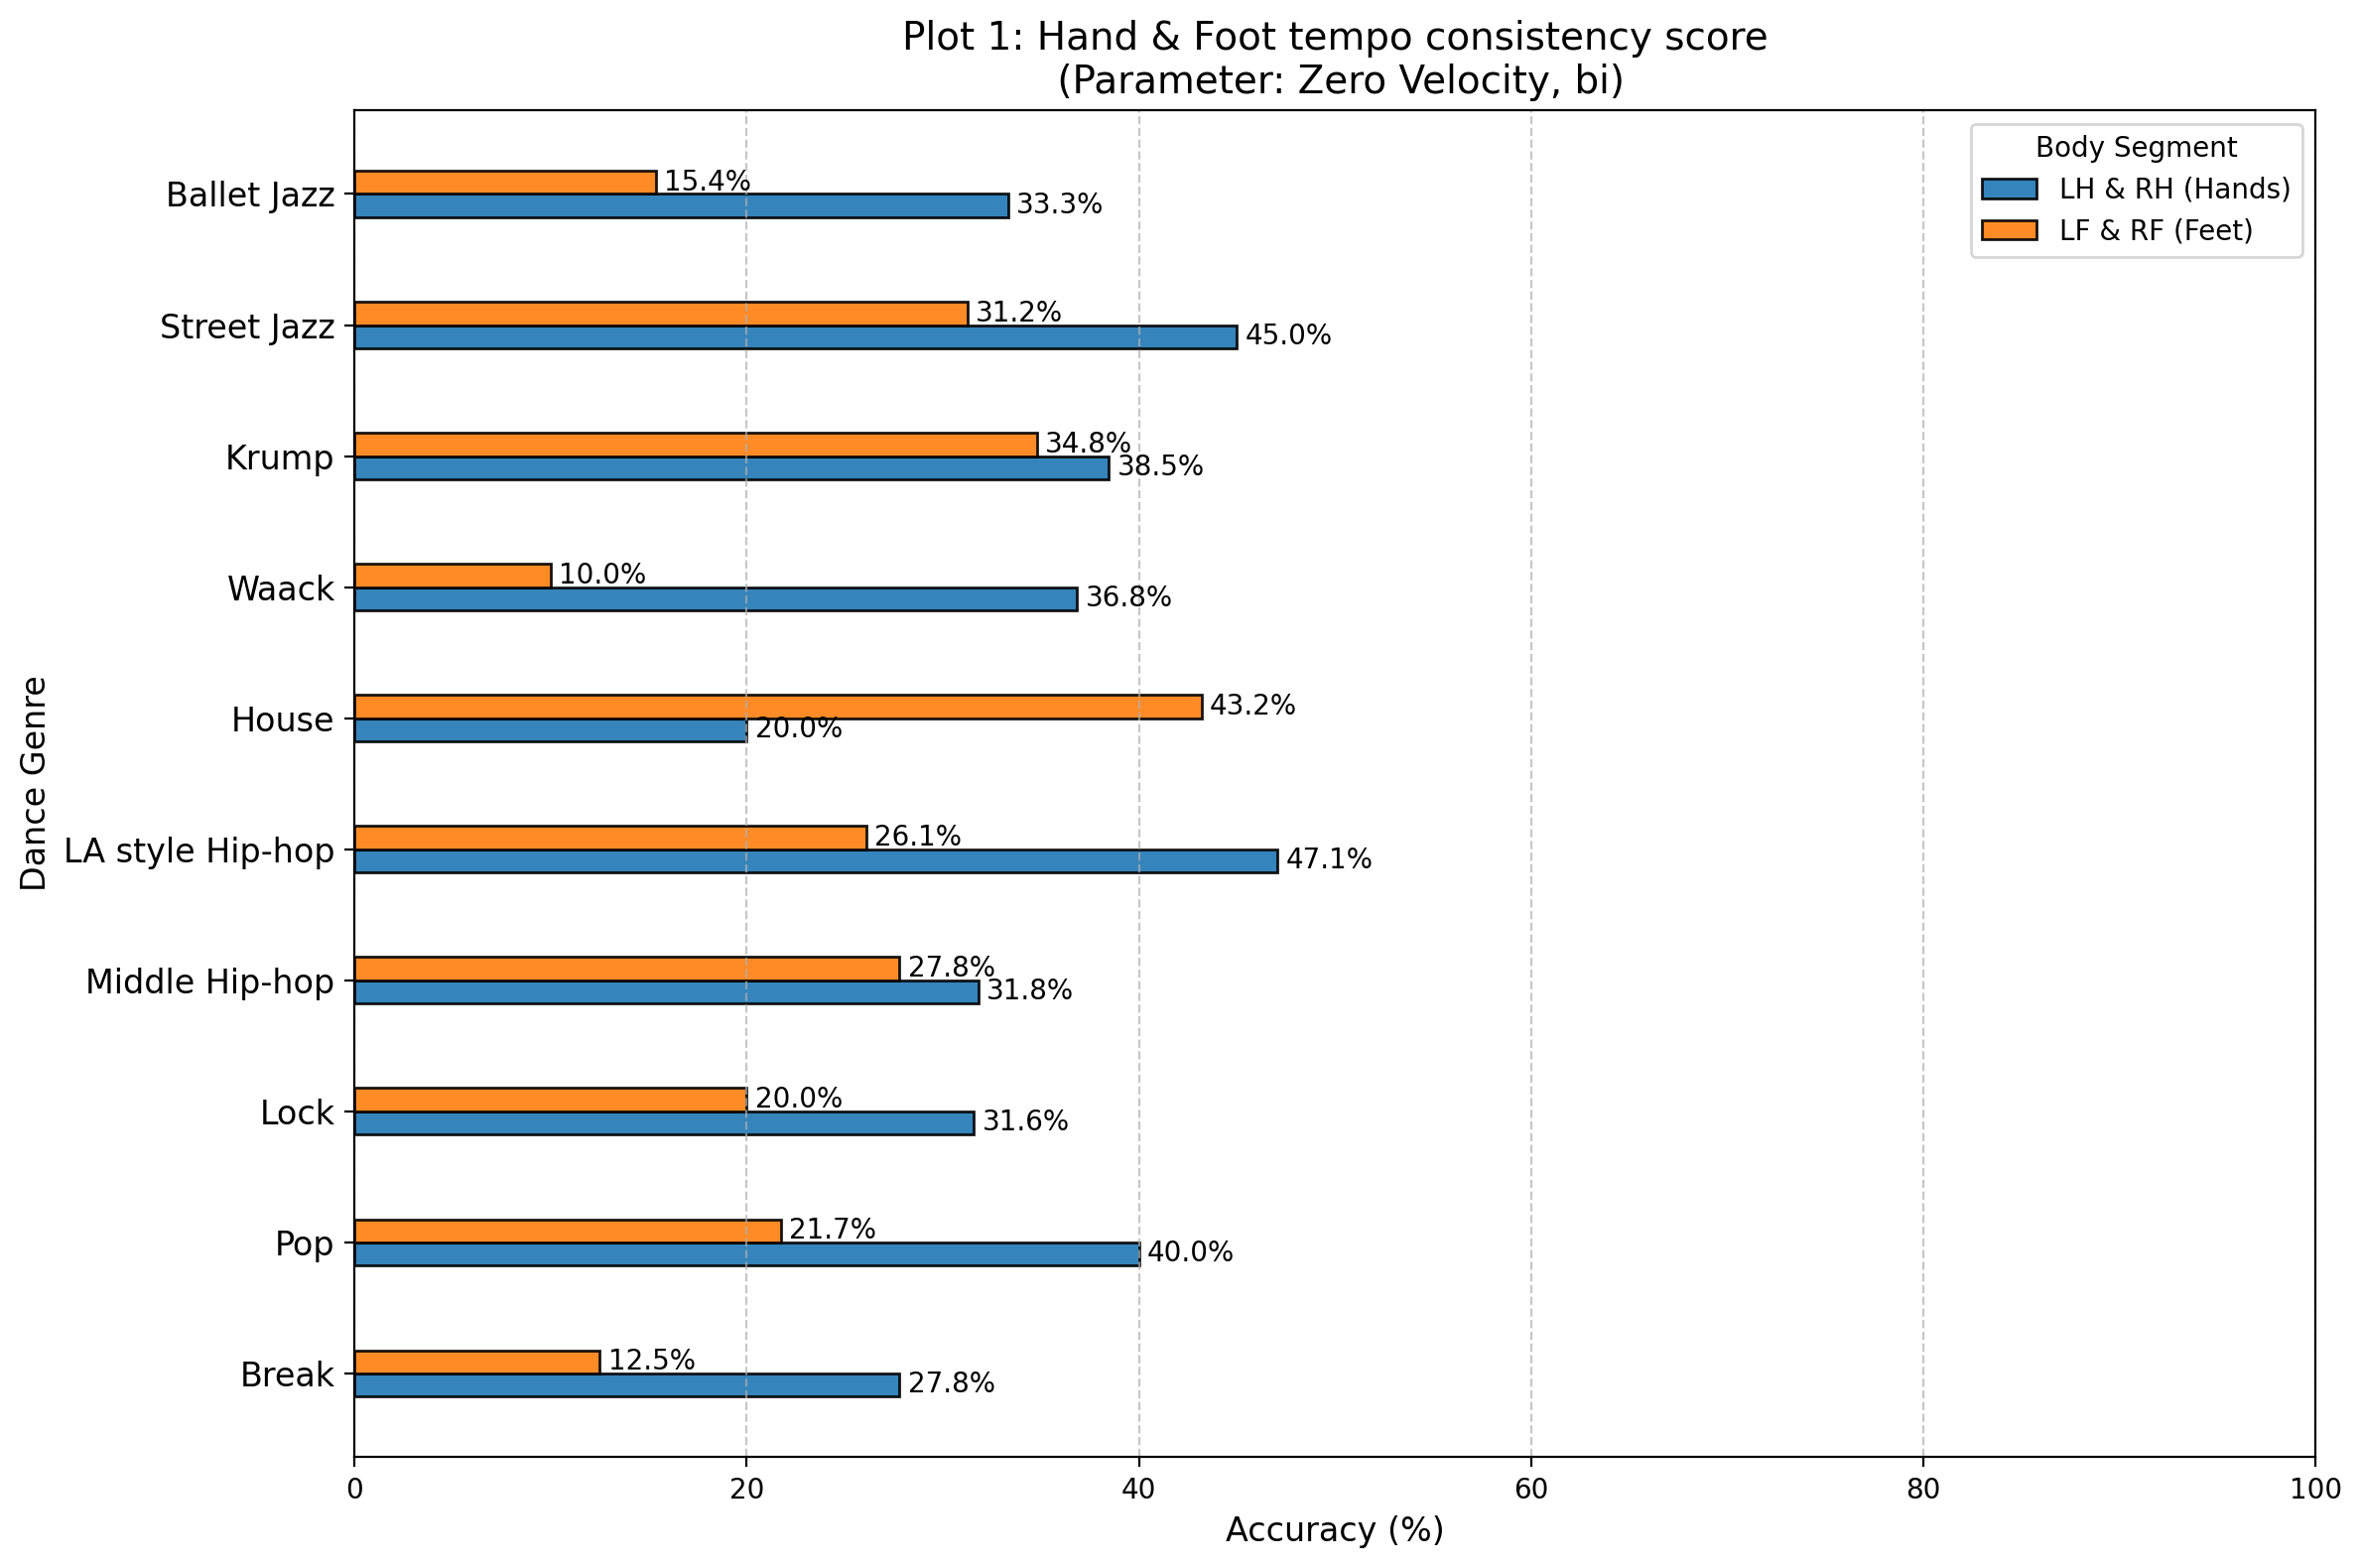

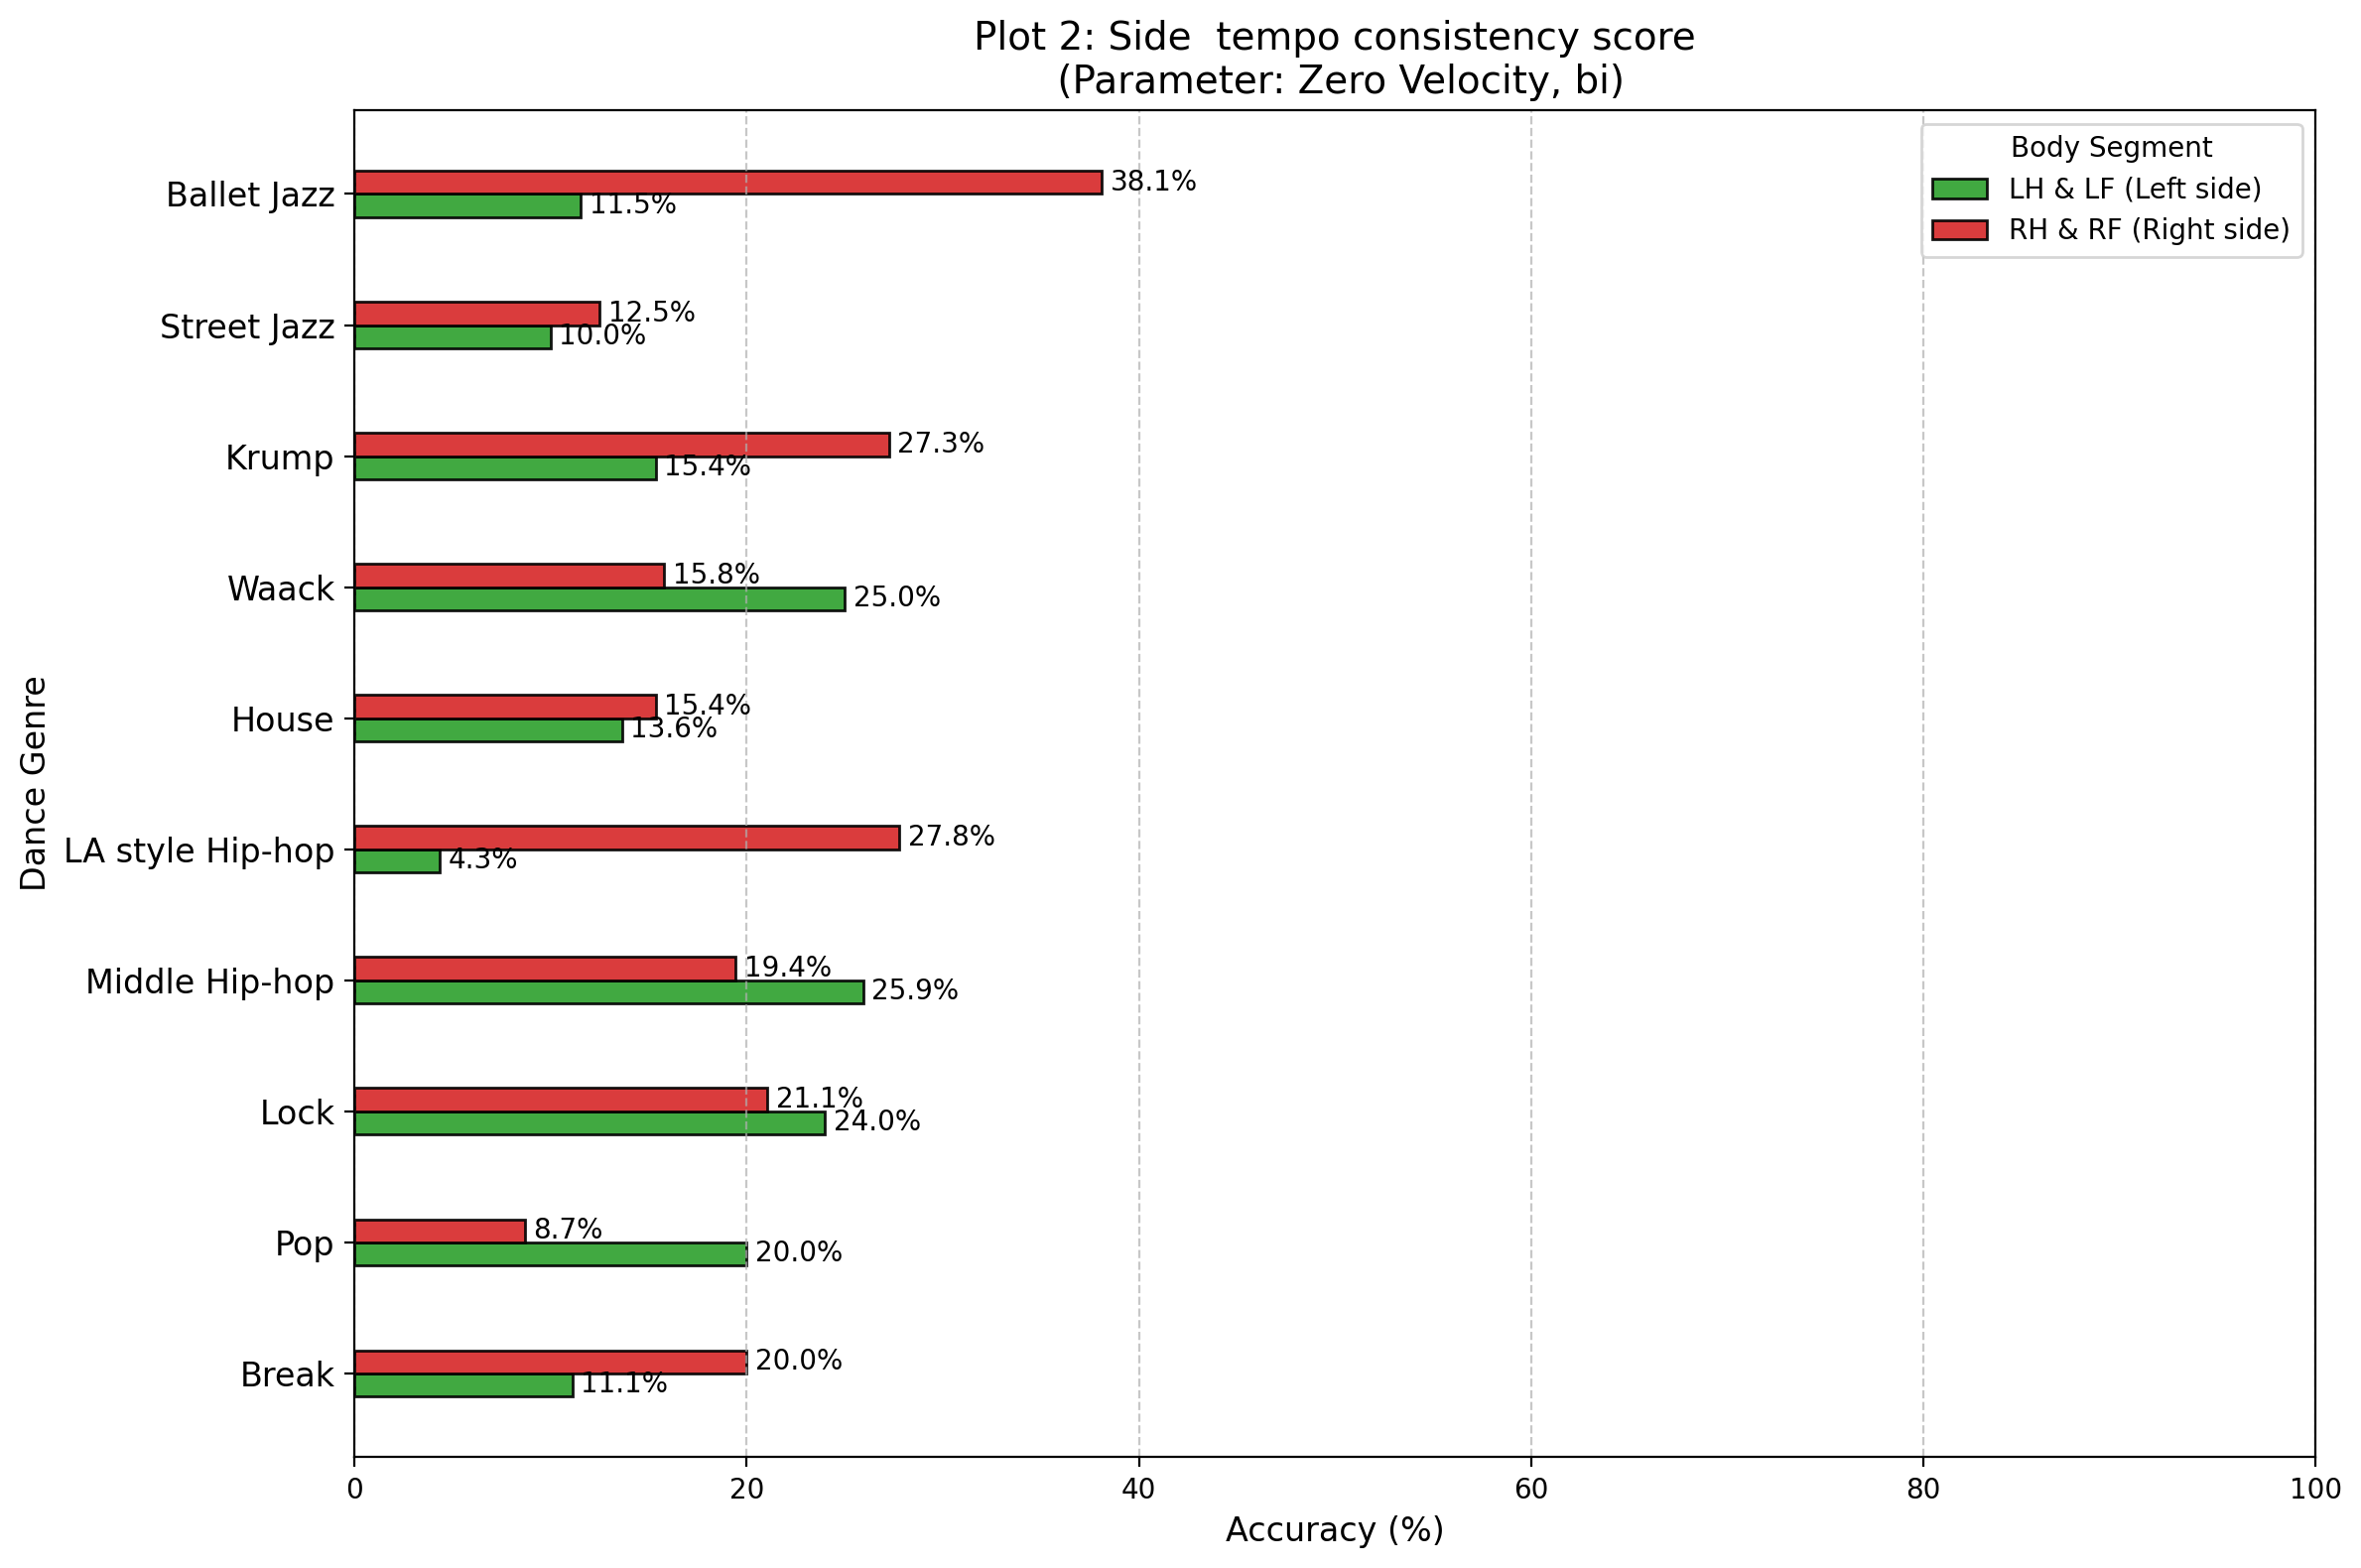

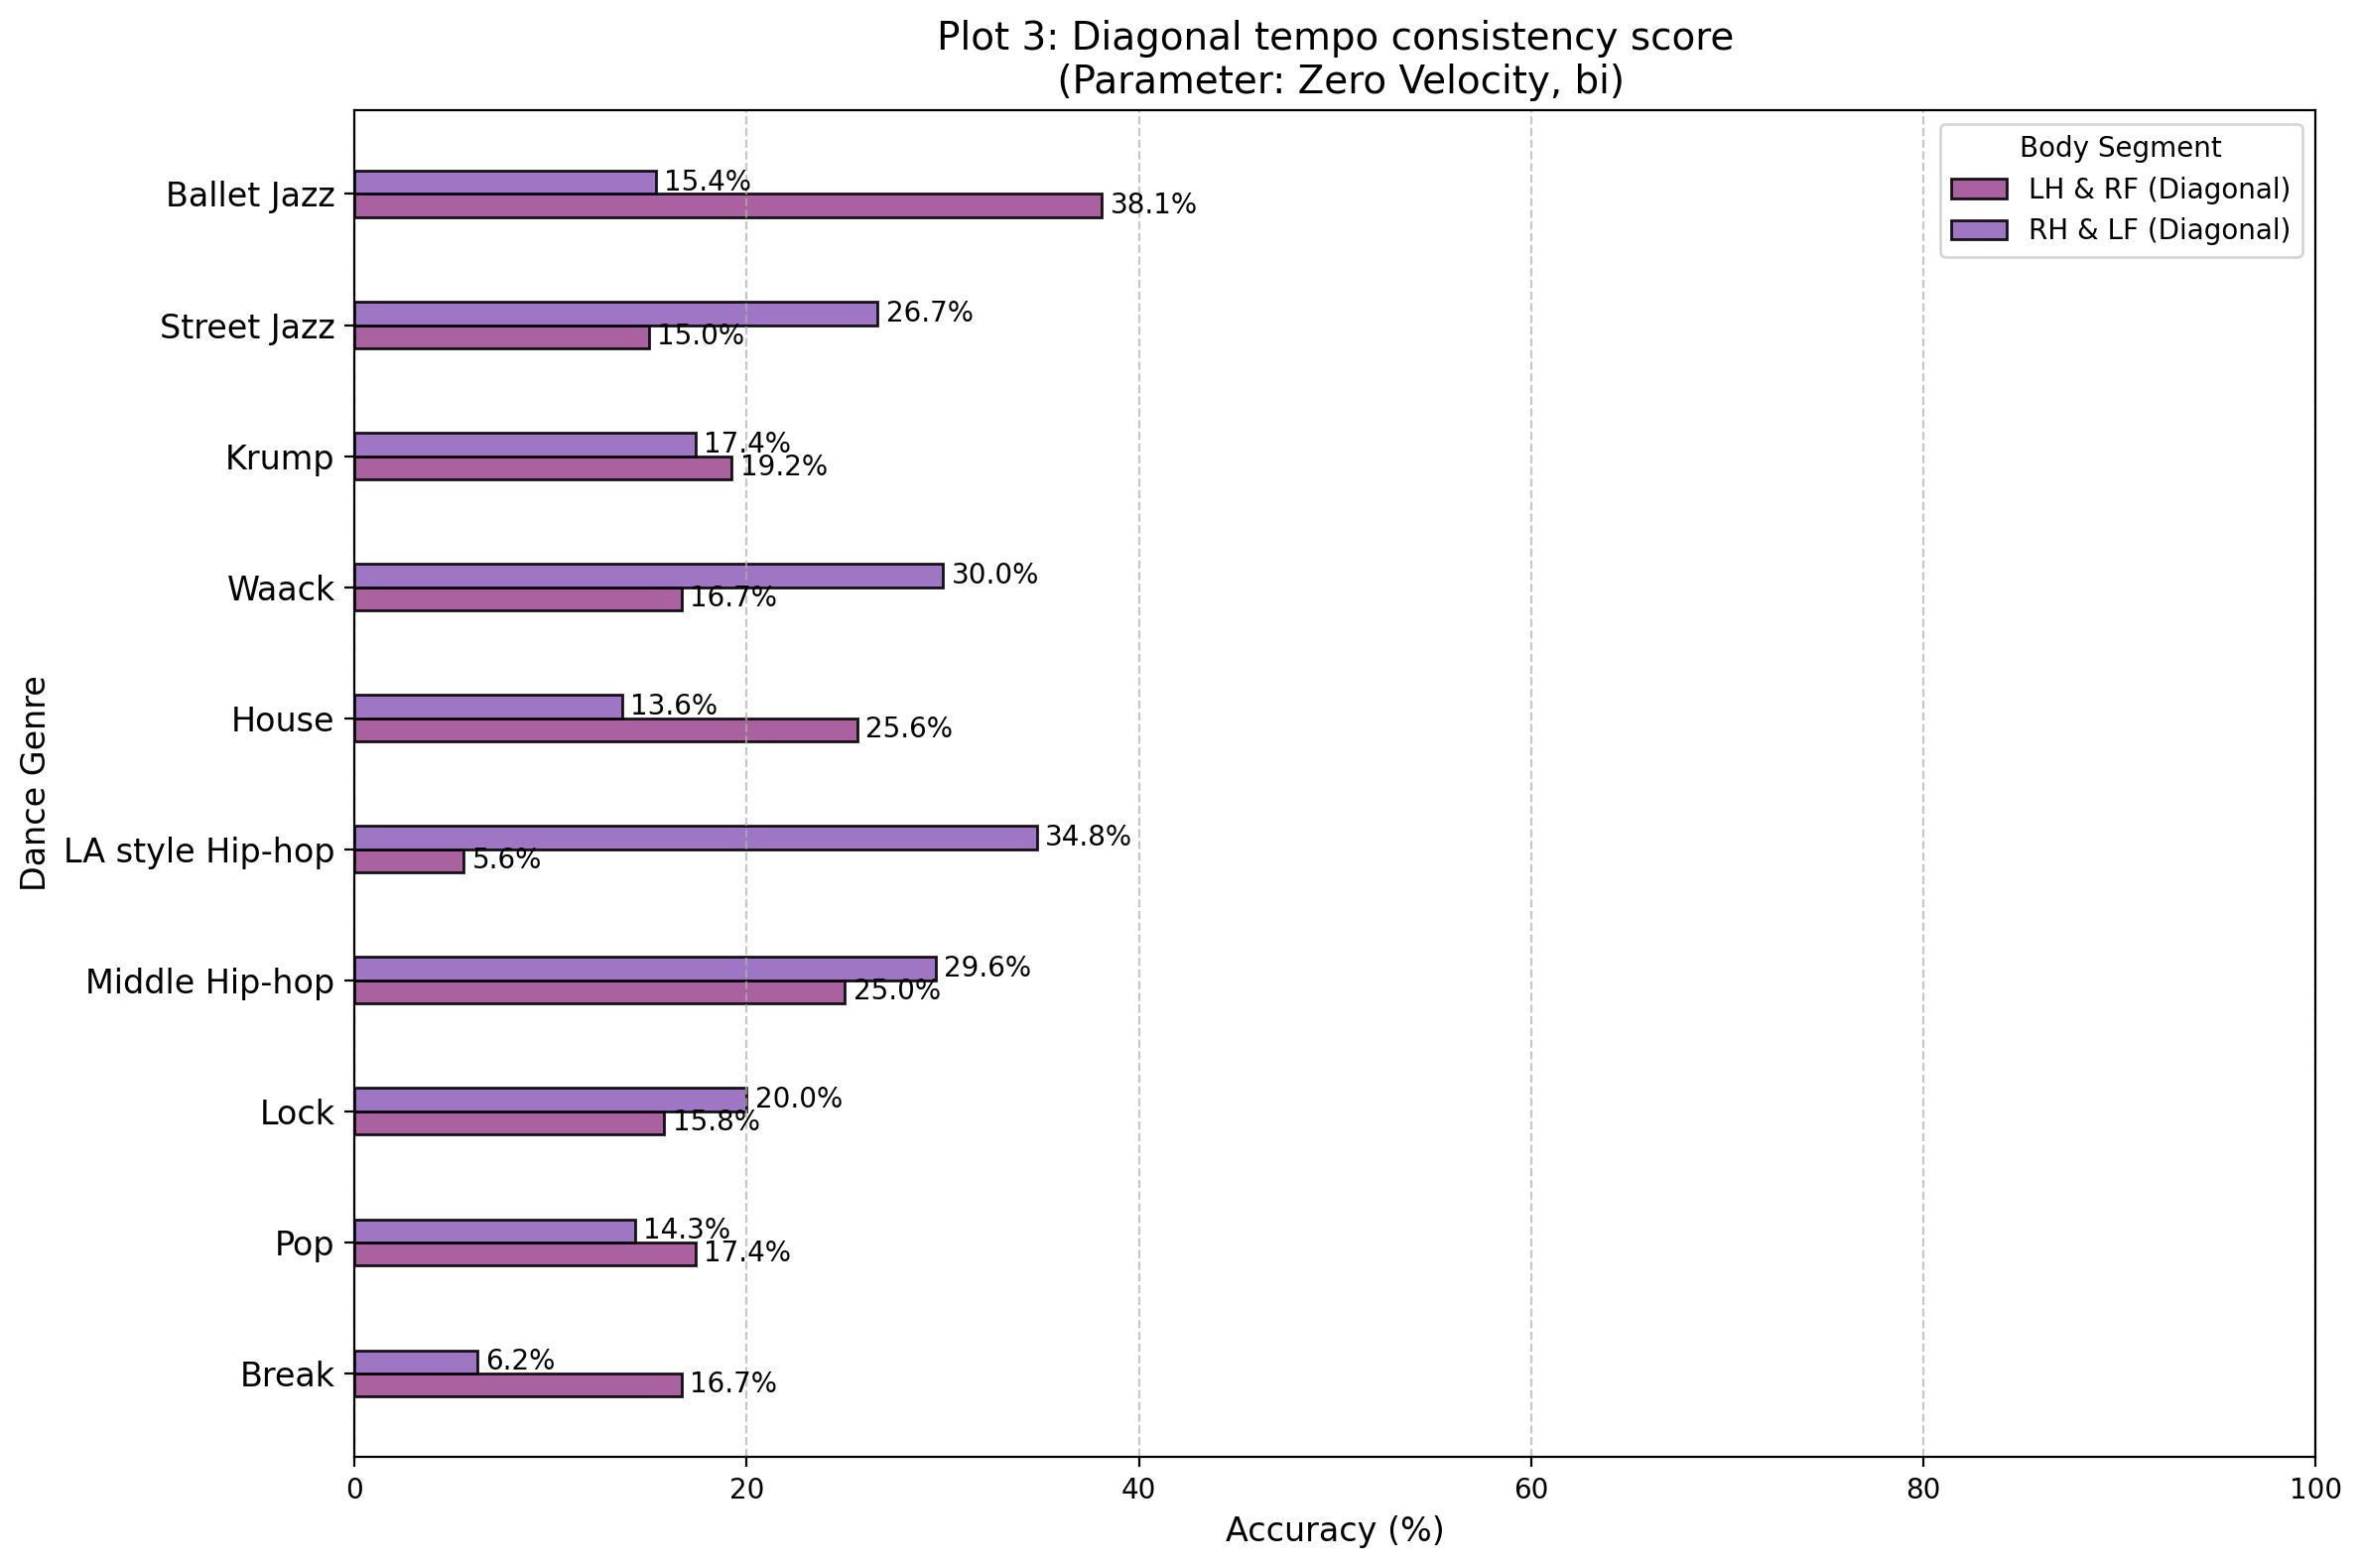

In [28]:
# Define subsets for each plot
plot_groups = [
    {
        "title": f"Plot 1: Hand & Foot tempo consistency score\n (Parameter: Zero Velocity, {mode})",
        "segments": ["Lhand-Rhand (Hands)", "Lfoot-Rfoot (Feet)"],
        "segment_labels": ["LH & RH (Hands)", "LF & RF (Feet)"],
        "colors": ['#1f77b4', '#ff7f0e']  # Blue for hands, Orange for feet
    },
    {
        "title": f"Plot 2: Side  tempo consistency score\n (Parameter: Zero Velocity, {mode})",
        "segments": ["Lhand-Lfoot (Left Side)", "Rhand-Rfoot (Right Side)"],
        "segment_labels": ["LH & LF (Left side)", "RH & RF (Right side)"],
        "colors": ['#2ca02c', '#d62728']  # Green for left side, Red for right side
    },
    {
        "title": f"Plot 3: Diagonal tempo consistency score\n (Parameter: Zero Velocity, {mode})",
        "segments": ["Lhand-Rfoot (Diagonal)", "Rhand-Lfoot (Diagonal)"],
        "segment_labels": ["LH & RF (Diagonal)", "RH & LF (Diagonal)"],
        "colors": ['#a05195', '#9467bd']  # Purple tones for diagonal pairs
    }
]

con_df = consistency_genrewise['bpm_avg_y']

# Set plot parameters
genres = con_df["genre"].tolist()
y = np.arange(len(genres)) * 2  # Space between genres
height = 0.35  # Thicker bars for better visibility

# Generate each plot separately
for group in plot_groups:
    fig, ax = plt.subplots(figsize=(12, 8), dpi=200)
    bars = []

    for i, (segment, color) in enumerate(zip(group["segments"], group["colors"])):
        bar = ax.barh(
            y + i * height,
            con_df[segment],
            height,
            label=group["segment_labels"][i],
            color=color,
            edgecolor='black',
            alpha=0.9
        )
        bars.append(bar)

    # Plot aesthetics
    ax.set_xlabel('Accuracy (%)', fontsize=12)
    ax.set_ylabel('Dance Genre', fontsize=12)
    ax.set_title(group["title"], fontsize=14)
    ax.set_yticks(y + height * (len(group["segments"]) - 1) / 2)
    ax.set_yticklabels(genres, fontsize=12)
    ax.set_xlim(0, 100)
    ax.legend(title="Body Segment", loc='upper right', fontsize=10)

    # Grid and bar labels
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    for bar_group in bars:
        ax.bar_label(bar_group, fmt='%.1f%%', label_type='edge', padding=3, fontsize=10)

    plt.tight_layout()
    plt.show()


##### Tempo Consistency Score Distributions Across Genres (Boxplot)

/tmp/ipykernel_3274910/1050392356.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


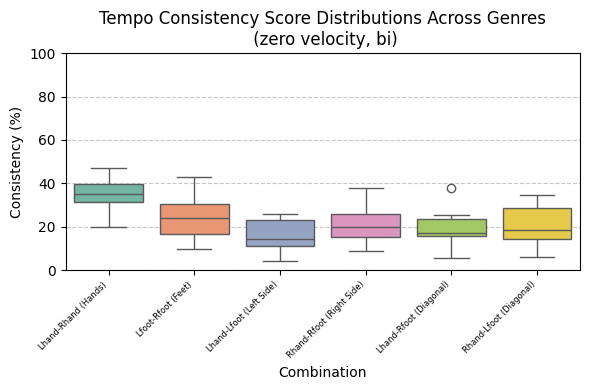

In [29]:
# Assuming consistency_df is already loaded with these columns:
# ['genre', 'Lhand-Rhand (Hands)', 'Lfoot-Rfoot (Feet)',
#  'Lhand-Lfoot (Left Side)', 'Rhand-Rfoot (Right Side)',
#  'Lhand-Rfoot (Diagonal)', 'Rhand-Lfoot (Diagonal)']

# Reshape the dataframe for seaborn (long-form DataFrame)
combination = [
    "Lhand-Rhand (Hands)",
    "Lfoot-Rfoot (Feet)",
    "Lhand-Lfoot (Left Side)",
    "Rhand-Rfoot (Right Side)",
    "Lhand-Rfoot (Diagonal)",
    "Rhand-Lfoot (Diagonal)"
]

df_long = con_df.melt(
    id_vars=["genre"],
    value_vars=combination,
    var_name="Synchronization Type",
    value_name="Consistency (%)"
)

# Create the boxplot
plt.figure(figsize=(6, 4), dpi=100)
# sns.set(style="whitegrid")

sns.boxplot(
    data=df_long,
    x="Synchronization Type",
    y="Consistency (%)",
    palette="Set2"
)

# Plot aesthetics
plt.title(f"Tempo Consistency Score Distributions Across Genres\n (zero velocity, {mode})")
plt.xlabel("Combination")
plt.ylabel("Consistency (%)")
plt.xticks(rotation=45, ha='right', fontsize = 6)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


#### zero velocity vs peak velocity

In [ ]:
a = 70
b = 145
mode = "uni"
norm_mode = "z-score"

pos_uni = pd.read_csv(f"./stats_pos/{norm_mode}/tempo_{a}_{b}/{mode}/hits_{mode}_{a}_{b}.csv")
vel_uni = pd.read_csv(f"./stats_vel/{norm_mode}/tempo_{a}_{b}/{mode}/hits_{mode}_{a}_{b}.csv")

# Select relevant columns
pos_df = pos_uni[["segment", "hits_percentage"]].rename(columns={"hits_percentage": "Position Hits (%)"})
vel_df = vel_uni[["segment", "hits_percentage"]].rename(columns={"hits_percentage": "Velocity Hits (%)"})

# Merge position and velocity data on 'segment'
merged_df = pd.merge(pos_df, vel_df, on="segment")

# Plot parameters
x = np.arange(len(merged_df["segment"]))  # Segment indices
width = 0.35  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, merged_df["Position Hits (%)"], width, label='Zero velocity', color='#1f77b4')
bars2 = ax.bar(x + width/2, merged_df["Velocity Hits (%)"], width, label='Peak velocity', color='#ff7f0e')

# Add text labels on top of each bar
for bars in [bars1, bars2]:
    ax.bar_label(bars, fmt='%.1f%%', padding=3, fontsize=10)

# Plot aesthetics
ax.set_ylabel('Estimation Accuracy (%)', fontsize=12)
ax.set_xlabel('Body Segment', fontsize=12)
ax.set_title(f'Overall Accuracy per Body Segment\n(zero velocity vs. peak velocity)\n ({mode}-directional, Tempo {a}-{b} BPM)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(merged_df["segment"], rotation=45, ha='right', fontsize=10)
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax.legend(title="Parameter", fontsize=11, title_fontsize=12)

plt.tight_layout()
plt.show()

#### Tempo Estimation Accuracy per Body Segment by Genre

In [ ]:
foot1s_name = "right_ankle"
foot_1S_df = pd.read_csv(f"./aist_pos1s/{norm_mode}/tempo_{a}_{b}/foot/{foot1s_name}_zero_{mode}_{a}_{b}.csv")

# Load genre mappings
with open("genreID_count_mapping.json", "r") as file:
    genre_Tcount = json.load(file)

with open("genre_symbols_mapping.json", "r") as file:
    genre_name = json.load(file)

# Hits index for each segment
hits_list = {
    "Lh": Lh_hits_idx,  # Left Hand
    "Rh": Rh_hits_idx,  # Right Hand
    "Lf": Lf_hits_idx,  # Left Foot
    "Rf": Rf_hits_idx,  # Right Foot
    "Combined": all_hits_idx  # Combined Union
}

# Initialize final dataframe with unique genres
final_df = pd.DataFrame(list(genre_name.items()), columns=["dance_genre", "genre"])
final_df["total"] = final_df["dance_genre"].map(genre_Tcount)

# For each body segment, calculate counts and percentages
for key, item in hits_list.items():
    hit_idx = list(item)
    hit_df = foot_1S_df.iloc[hit_idx]       # df for estimated hits
    grouped = hit_df.groupby(['dance_genre']).size().reset_index(name=f'{key}_count') # estimated count per dance genre

    # Merge counts with final dataframe
    final_df = final_df.merge(grouped, on='dance_genre', how='left')
    final_df[f'{key}_count'] = final_df[f'{key}_count'].fillna(0).astype(int)
    final_df[f'{key}_percentage'] = round((final_df[f'{key}_count'] / final_df['total']) * 100, 2)

# Drop unnecessary columns and reorder
final_df = final_df.drop(columns=["dance_genre"])
final_df = final_df[['genre'] + [f'{k}_{m}' for k in hits_list.keys() for m in ["count", "percentage"]]]

barplot v1: 

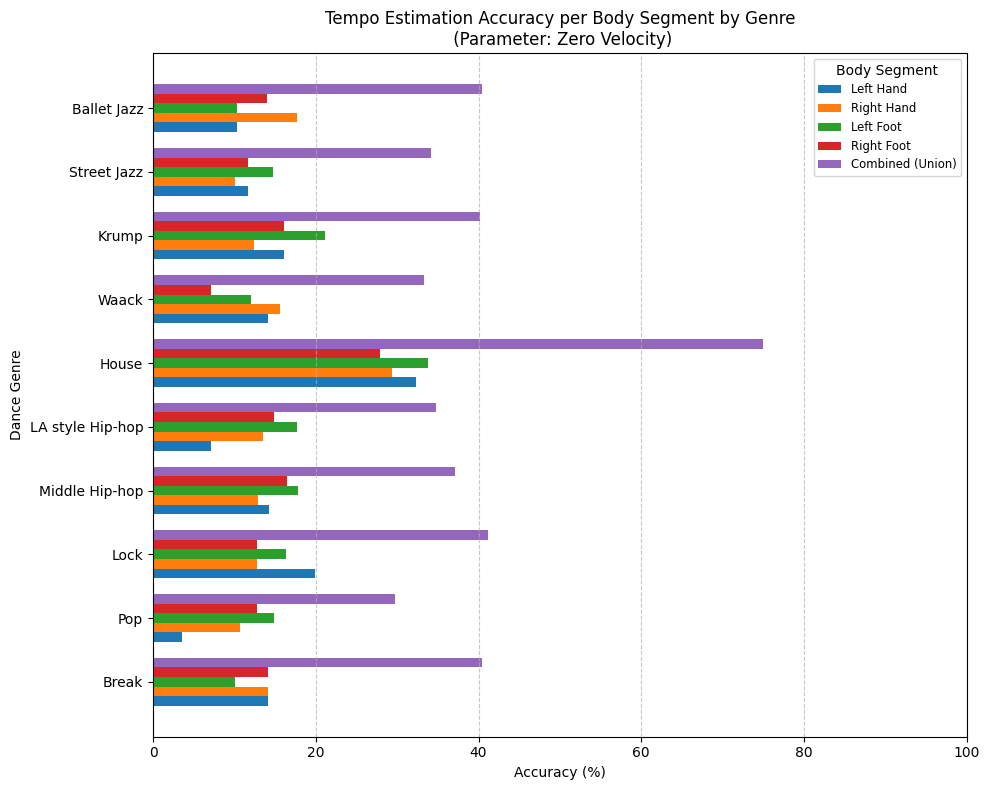

In [32]:
# Define body segments for plotting
segments = ["left_hand_percentage", "right_hand_percentage", "left_foot_percentage", "right_foot_percentage", "Combined_percentage"]
segment_labels = ["Left Hand", "Right Hand", "Left Foot", "Right Foot", "Combined (Union)"]


# Set plot parameters
genres = json_hits_genrewise['bpm_avg_x']["genre"].tolist()
y = np.arange(len(genres))  # the label locations
height = 0.15  # the height of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each segment as a group (horizontal)
for i, segment in enumerate(segments):
    ax.barh(y + i * height, json_hits_genrewise['bpm_avg_x'][segment], height, label=segment_labels[i])

# Add labels, title, and legend
ax.set_xlabel('Accuracy (%)')
ax.set_ylabel('Dance Genre')
ax.set_title('Tempo Estimation Accuracy per Body Segment by Genre\n (Parameter: Zero Velocity)')
ax.set_yticks(y + height * (len(segments) - 1) / 2)
ax.set_yticklabels(genres)
ax.set_xlim(0, 100)
ax.legend(title="Body Segment", loc='upper right', fontsize='small')

# Add grid and data labels on bars
ax.grid(axis='x', linestyle='--', alpha=0.7)
# for bar_group in ax.containers:
#     ax.bar_label(bar_group, fmt='%.1f%%', padding=5, label_type='center')

plt.tight_layout()
plt.show()

#### Barplot v2: Tempo Estimation Accuracy per Body Segment by Genre

In [ ]:
# Define body segments for plotting
segments = ["Lh_percentage", "Rh_percentage", "Lf_percentage", "Rf_percentage", "Combined_percentage"]
segment_labels = ["Left Hand", "Right Hand", "Left Foot", "Right Foot", "Combined"]

# Group color: Hands (Blues), Feet (Greens), Combined (Gray)
colors = ['#1f77b4', '#1f77b4', '#2ca02c', '#2ca02c', '#a05195']  # Similar colors for hands & feet

# Hatching patterns for additional distinction
hatches = ['/', '\\', '/', '\\', '']

# Set plot parameters
genres = final_df["genre"].tolist()
y = np.arange(len(genres))
height = 0.15  # Height of each bar

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

bars = []
# Plot each segment with color and hatch
for i, (segment, color, hatch) in enumerate(zip(segments, colors, hatches)):
    bar = ax.barh(y + i * height, final_df[segment], height, label=segment_labels[i],
                  color=color, hatch=hatch, edgecolor='black', alpha=0.9)
    bars.append(bar)

# Plot aesthetics
ax.set_xlabel('Accuracy (%)', fontsize=12)
ax.set_ylabel('Dance Genre', fontsize=12)
ax.set_title(f'Tempo Estimation Accuracy per Body Segment by Genre\n (Parameter: Zero Velocity, {mode})')
ax.set_yticks(y + height * (len(segments) - 1) / 2)
ax.set_yticklabels(genres, fontsize=12)
ax.set_xlim(0, 100)
ax.legend(title="Body Segment", loc='upper right', fontsize=12)

# Grid and labels
ax.grid(axis='x', linestyle='--', alpha=0.7)
# for bar_group in bars:
#     ax.bar_label(bar_group, fmt='%.1f%%', label_type='edge', padding=3, fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# mode = "uni"
# a = 70; b = 145
# hand1s_name = "right_wrist"
# foot1s_name = "left_ankle"
# side_hand = hand1s_name.split("_")[0].capitalize()
# side_foot = foot1s_name.split("_")[0].capitalize()

# norm_mode = "z-score"

# foot_1S_df = pd.read_csv(f"./aist_pos1s/{norm_mode}/tempo_{a}_{b}/foot/{foot1s_name}_zero_{mode}_{a}_{b}.csv")
# foot_2S_df = pd.read_csv(f"./aist_pos2s/{norm_mode}/tempo_{a}_{b}/foot/foot_zero_{mode}_{a}_{b}.csv")

# foot_1s_score = pd.read_csv(f"./aist_pos1s/{norm_mode}/tempo_{a}_{b}/score/foot/{foot1s_name}_{mode}_{a}_{b}_score.csv")
# hand_1s_score = pd.read_csv(f"./aist_pos1s/{norm_mode}/tempo_{a}_{b}/score/hand/{hand1s_name}_{mode}_{a}_{b}_score.csv")

# foot_2s_score = pd.read_csv(f"./aist_pos2s/{norm_mode}/tempo_{a}_{b}/score/foot/foot_{mode}_{a}_{b}_score.csv")
# hand_2s_score = pd.read_csv(f"./aist_pos2s/{norm_mode}/tempo_{a}_{b}/score/hand/hand_{mode}_{a}_{b}_score.csv")

# foot_1s_score["hits_idx"] = foot_1s_score["hits_idx"].apply(ast.literal_eval)   # convert string to list
# hand_1s_score["hits_idx"] = hand_1s_score["hits_idx"].apply(ast.literal_eval)

# foot_2s_score["hits_idx"] = foot_2s_score["hits_idx"].apply(ast.literal_eval)
# hand_2s_score["hits_idx"] = hand_2s_score["hits_idx"].apply(ast.literal_eval)

# total = foot_2S_df.shape[0]

# # genre id and total count mapping
# json_filename = "genreID_count_mapping.json"
# with open(json_filename, "r") as file:
#     genre_Tcount = json.load(file)
    
# # genre id and name mapping
# json_filename = "genre_symbols_mapping.json"
# with open(json_filename, "r") as file:
#     genre_name = json.load(file)  

In [ ]:
# def calc_hits(foot_score, hand_score):

#     foot_hits = set(foot_score)
#     hand_hits = set(hand_score)
#     combined_hits = foot_hits.union(hand_hits)
#     common_hits = foot_hits.intersection(hand_hits)
#     foot_only_hits = len(foot_hits)-len(common_hits)
#     hand_only_hits = len(hand_hits)-len(common_hits)
    
#     print("total:", total)
#     print("foot hits:", len(foot_hits), f"({round(len(foot_hits)*100/total, 2)} %)" )
#     print("hand hits:", len(hand_hits), f"({round(len(hand_hits)*100/total, 2)} %)" )
#     print("combined hits:", len(combined_hits), f"({round(len(combined_hits)*100/total, 2)} %)" )
#     print("common hits:", len(common_hits))
#     print("foot - common:", foot_only_hits)
#     print("hand - common:", hand_only_hits)
    
#     return foot_hits, hand_hits, combined_hits, common_hits, foot_only_hits, hand_only_hits

# print(10*"*"+f"1-Sensor {mode}"+ 10*"*")
# foot1S_hits, hand1S_hits, combined1S_hits, common1S_hits, foot_only1S_hits, hand_only1S_hits = calc_hits(foot_1s_score["hits_idx"][3], hand_1s_score["hits_idx"][3])

# print(10*"*"+f"2-Sensor {mode}"+ 10*"*")
# foot2S_hits, hand2S_hits, combined2S_hits, common2S_hits, foot_only2S_hits, hand_only2S_hits = calc_hits(foot_2s_score["hits_idx"][3], hand_2s_score["hits_idx"][3])

In [ ]:
# # Define hit counts
# hit_counts = {
#     "total": total,
#     "foot1S_hits": len(foot1S_hits),
#     "hand1S_hits": len(hand1S_hits),
#     "combined1S_hits": len(combined1S_hits),
#     "common1S_hits": len(common1S_hits),
#     # "foot_only1S_hits": foot_only1S_hits,   # foot - common hits
#     # "hand_only1S_hits": hand_only1S_hits,   # hand - common hits
    
#     "foot2S_hits": len(foot2S_hits),
#     "hand2S_hits": len(hand2S_hits),
#     "combined2S_hits": len(combined2S_hits),
#     "common2S_hits": len(common2S_hits),
#     # "foot_only2S_hits": (foot_only2S_hits),
#     # "hand_only2S_hits": hand_only2S_hits,
# }

# hit_data = [{"hit_type": key, "hit": value} for key, value in hit_counts.items() if key != "total"]
# hit_total = pd.DataFrame(hit_data)
# hit_total["percentage"] = round((hit_total["hit"] / hit_counts["total"]) * 100, 2)
# hit_total["method"] = hit_total["hit_type"].apply(lambda x: "1S" if "1S" in x else "2S")

# # Add 'label' column based on 'hit_type'
# hit_total["label"] = hit_total["hit_type"].apply(
#     lambda x: f"{side_foot} Foot" if x == "foot1S_hits" else
#               f"{side_hand} Hand" if x == "hand1S_hits" else
#               f"{side_hand} Hand+{side_foot} Foot" if x == "combined1S_hits" else
#               "Mutual" if x == "common1S_hits" else
#               "Both Feet" if x == "foot2S_hits" else
#               "Both Hand" if x == "hand2S_hits" else
#               "Both Hand+Foot" if x == "combined2S_hits" else
#               "Mutual"  # For common2S_hits
# )
# # Reorder columns
# hit_total = hit_total[["hit_type", "label", "hit", "percentage", "method"]]
# hit_total.to_csv(f"./stats/{norm_mode}/tempo_{a}_{b}/{mode}/hits_total/{hand1s_name}_{foot1s_name}.csv", index=False)

# # hit_total = pd.read_csv(f"./stats/tempo_{a}_{b}/{mode}/hits_total/left_wrist_left_ankle.csv")

# plt.figure(figsize=(6, 4))
# sns.barplot(data=hit_total, x="percentage", y="label",hue="method", orient="h",)

# # Formatting
# plt.xlabel("Percentage of Hits (%)")
# plt.ylabel("")
# plt.title(f"Hit Detection Overview ({a}, {b})\n")
# plt.legend(title="Sensor")
# plt.grid(axis='x', linestyle="--", alpha=0.7, which='both')
# plt.xticks(np.arange(0, 100+1, 10))

# # plt.savefig("./stats/total_hits.png")
# plt.show()

In [ ]:
# # mode = "uni"
# # a = 60; b = 180

# config_hits = {
#     "combined_1S_2S": {
#         "L1": [combined1S_hits, combined2S_hits],
#         "para": ["combined_hits_1S", "combined_hits_2S", f"./stats/{norm_mode}/tempo_{a}_{b}/{mode}/genre_wise/combined_genrewise_hits"]
#     },
#     "hand_1S": {
#         "L1": [hand1S_hits, foot1S_hits],
#         "para": ["hand_hits_1S", "foot_hits_1S", f"./stats/{norm_mode}/tempo_{a}_{b}/{mode}/genre_wise/handfoot_1S_genrewise_hits"]
#     },
#     "hand_2S": {
#         "L1": [hand2S_hits, foot2S_hits],
#         "para": ["hand_hits_2S", "foot_hits_2S", f"./stats/{norm_mode}/tempo_{a}_{b}/{mode}/genre_wise/handfoot_2S_genrewise_hits"]
#     }
# }

# # Loop through each configuration
# for key, cfg in config_hits.items():
#     L1 = cfg["L1"]
#     para = cfg["para"]

#     column_names = ["Agenre_name", f"A{para[0]}", "Atotal", "Apercentage",
#                     "Bgenre_name", f"B{para[1]}", "Btotal", "Bpercentage"]

#     df_list = []
#     for item in L1:
#         hit_idx = list(item)
#         hit_df = foot_1S_df.iloc[hit_idx]  # Ensure foot_1S_df is defined
#         grouped = hit_df.groupby(['dance_genre']).size().reset_index(name='count')

#         # Add total and percentage columns
#         grouped['total'] = grouped['dance_genre'].map(genre_Tcount)
#         grouped['percentage'] = round((grouped['count'] / grouped['total']) * 100, 2)
#         grouped['genre_name'] = grouped['dance_genre'].map(genre_name)

#         # Keep only relevant columns
#         grouped = grouped[['genre_name', 'count', 'total', 'percentage']]
#         df_list.append(grouped)

#     # Concatenate and save final dataframe
#     final_df = pd.concat(df_list, axis=1)
#     final_df.columns = column_names
#     final_df.to_csv(para[2] + ".csv", index=False)

#     print(f"Saved CSV for {key}: {para[2]}.csv ✅")
